# Gradient Analysis
**Disclaimer:** The figures and results in the article are based on gradients averaged over 10 realizations of 10-fold CV. In this repo, we have included gradients from only one model, because each gradient file is 130MB in size

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

In [2]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

In [3]:
data = np.load('R2192_models/grads_R2192_1x1400_v1.npz')
#grads = data['grads'][:,:,:63]
grads = data['grads'][:,:,:63]
#onehot_grads = data['grads'][:,:,63:]
print "grads:", grads.shape
targets = data['targets']
print "targets:", targets.shape

grads: (4414, 100, 63)
targets: (4414, 2)


In [4]:
new_tgts=0
all_grads=[]

# For the article, this was actually done for 10 CV-runs, 
# but to limit repo size we have included only one set of grad to the repository
for i in range(1,2):
    data = np.load("R2192_models/grads_R2192_1x1400_v"+str(i)+".npz")
    grads = data['grads'][:,:,:63]
    print "shape of grads",grads.shape
    if i>1:
        assert(np.all(new_tgts==data["targets"]))
    new_tgts = data["targets"]
    all_grads.append(grads)

shape of grads (4414, 100, 63)


In [5]:
print np.shape(all_grads)
print np.min(all_grads)

raw_mean_grads = np.mean(all_grads, axis=0)

mean_grads = np.mean(np.abs(all_grads), axis=0)
print np.min(mean_grads)

print mean_grads.shape

(1, 4414, 100, 63)
-11.046605110168457
0.0
(4414, 100, 63)


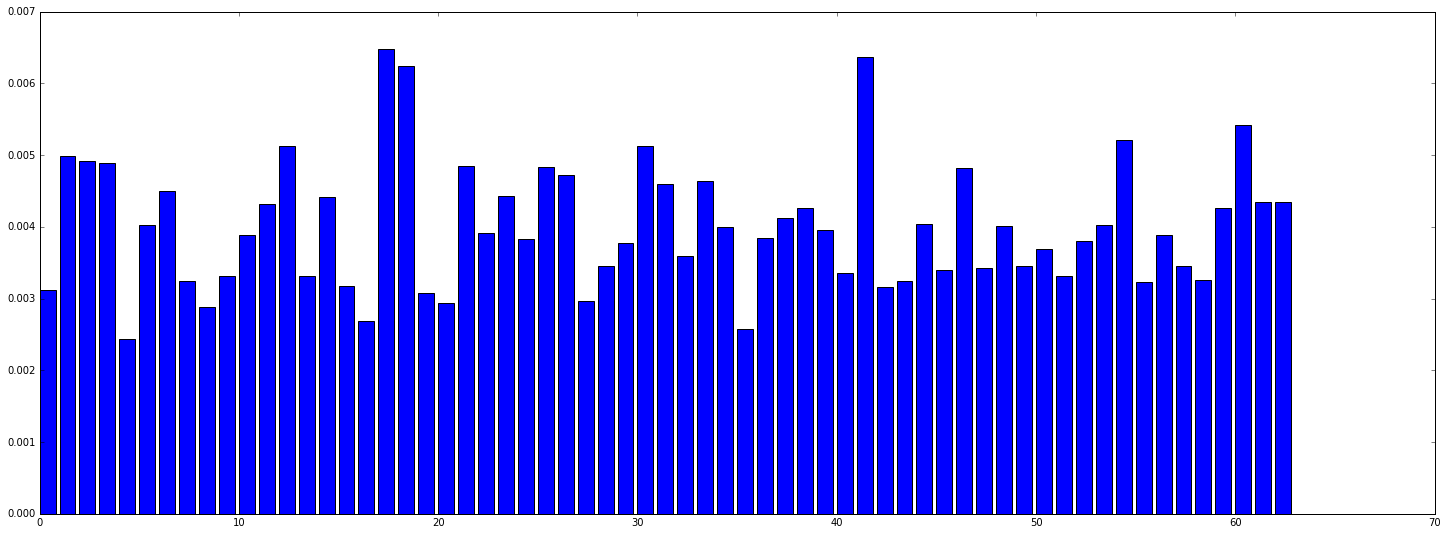

In [6]:
neuron_grads = np.mean(mean_grads, axis=(0,1))

plt.figure(figsize=(25,9))
plt.bar(range(neuron_grads.shape[0]), neuron_grads);

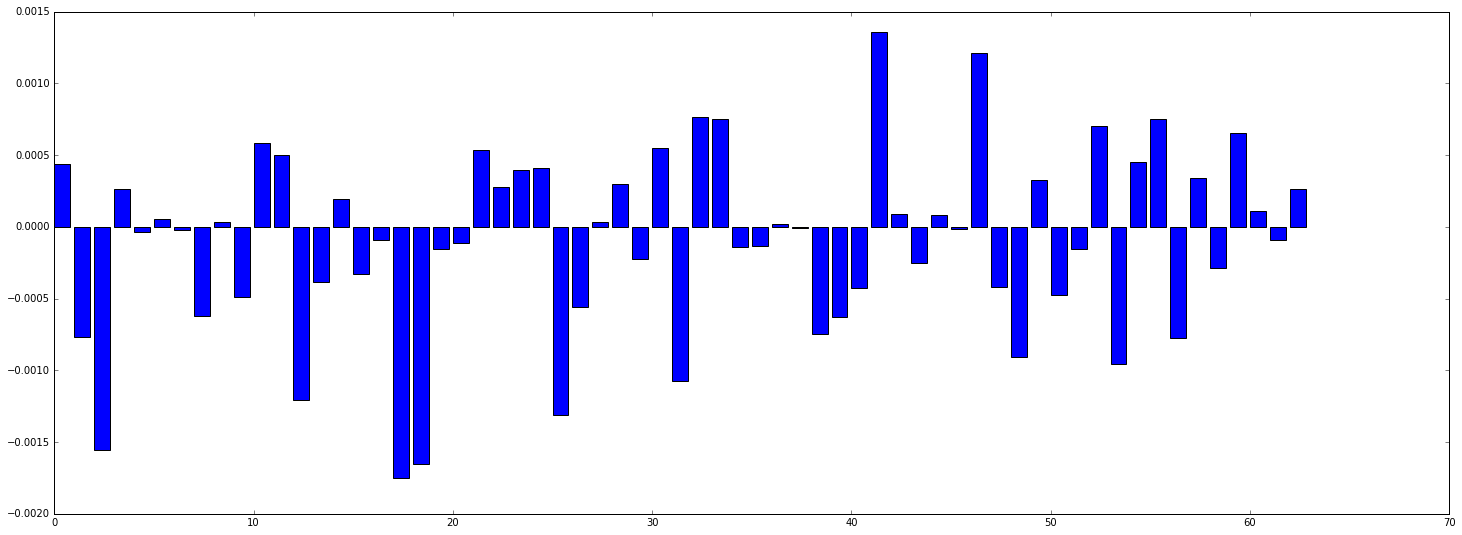

In [7]:
# infleunce of neurons
raw_neuron_grads = np.mean(raw_mean_grads, axis=(0,1))

plt.figure(figsize=(25,9))
plt.bar(range(raw_neuron_grads.shape[0]), raw_neuron_grads);

order of importance: [ 4 35 16  8 20 27 19  0 42 15 55 43  7 58 51  9 13 40 45 47 57 49 28 32
 50 29 52 24 36 10 56 22 39 34 48 53  5 44 37 59 38 11 61 62 14 23  6 31
 33 26 46 25 21  3  2  1 30 12 54 60 18 41 17]


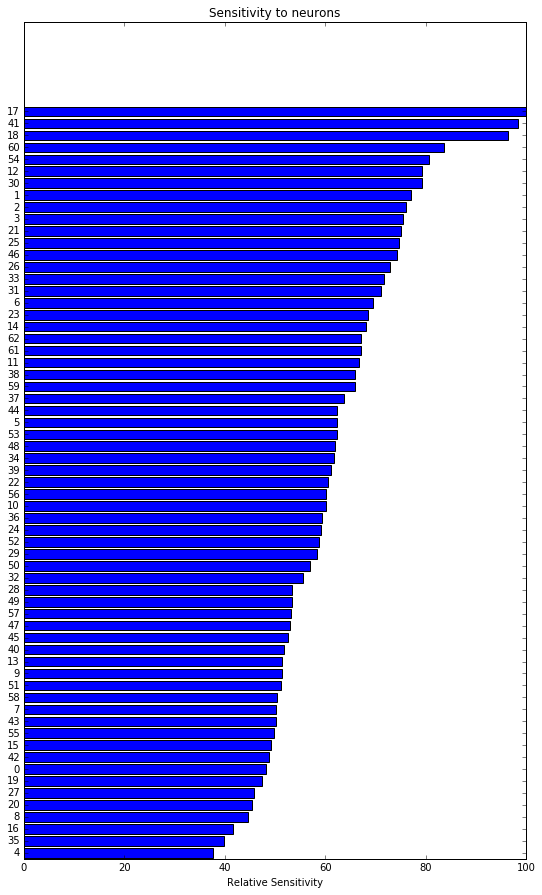

In [8]:
# Plot feature importance
feature_importance = neuron_grads
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
print "order of importance:", sorted_idx
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(9,15))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, sorted_idx)
plt.xlabel('Relative Sensitivity')
plt.title('Sensitivity to neurons')
plt.show()

In [9]:
from ratdata import load_data
X, y = load_data('data/R2192_1x1400_at35_step200_bin100-RAW_feat.dat', 'data/R2192_1x1400_at35_step200_bin100-RAW_pos.dat')

Original data: (5404, 63) (5404, 2)
minX/maxX/meanX/stdX/miny/maxy: 0.0 59.0 0.7402482581979251 2.3591926816354136 4.39033 107.044


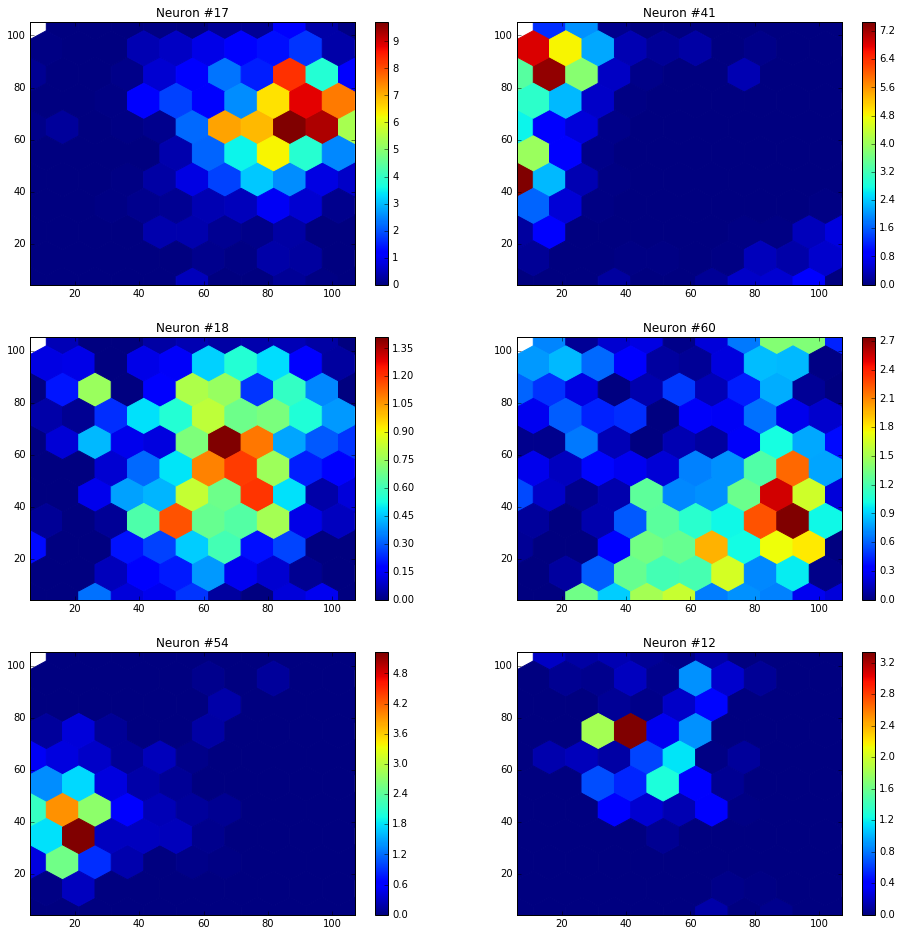

In [10]:
# activity of the most important neurons in 2D space (place fields)
plt.figure(figsize=(16,16))
for i in xrange(1,7):
    plt.subplot(3,2,i)
    plt.hexbin(y[...,0], y[...,1], X[...,sorted_idx[-i]], gridsize = 10)
    plt.colorbar()
    plt.title("Neuron #%d" % sorted_idx[-i])

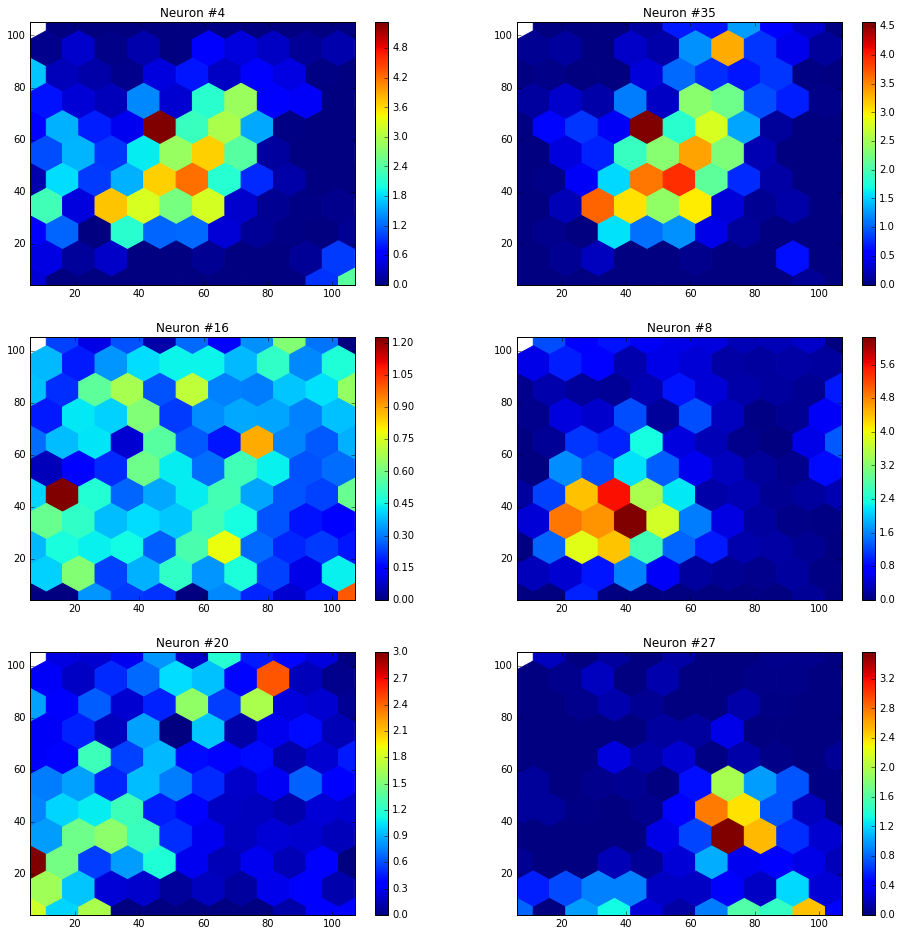

In [11]:
# activity of the least sensitive neurons in 2D space (place fields)
plt.figure(figsize=(16,16))
for i in xrange(1,7):
    plt.subplot(3,2,i)
    plt.hexbin(y[...,0], y[...,1], X[...,sorted_idx[i-1]], gridsize = 10)
    plt.colorbar()
    plt.title("Neuron #%d" % sorted_idx[i-1])


## 
## GRADIENTS IN SPACE
## 


(4414, 63) (5404, 2) (4414, 2)
True
(4414, 63)
center of mass of activity: [82.23547764 65.79647563]
center of mass of activity: [20.92263405 73.69925838]
center of mass of activity: [64.03700156 54.92896809]
center of mass of activity: [69.20396977 47.48322638]
center of mass of activity: [25.9900509  47.01829119]
[20.0, 20.0, 20.0, 20.0, 21.0, 21.0, 22.0, 23.0, 23.0, 24.0]


<Figure size 1224x1728 with 0 Axes>

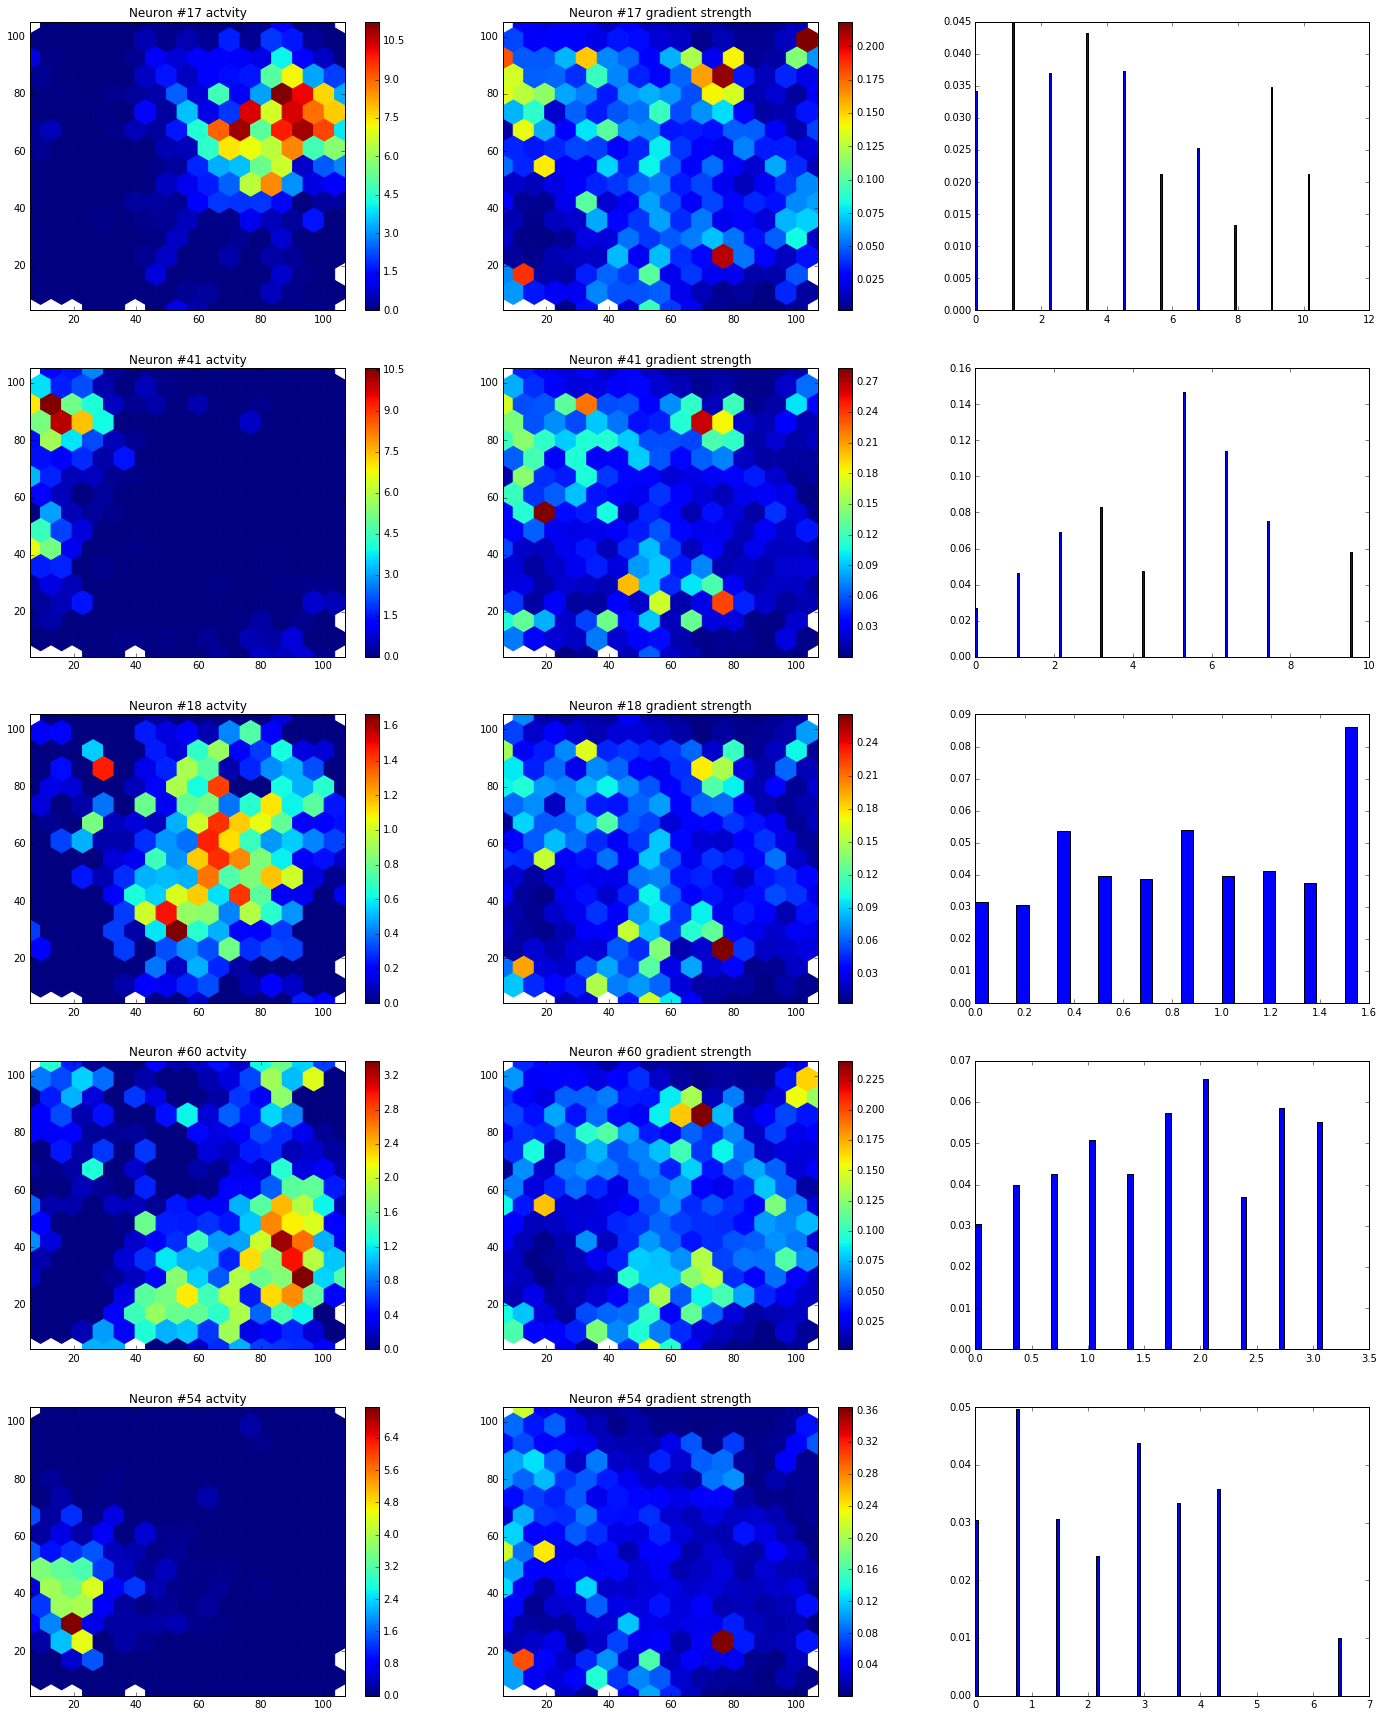

In [12]:
from scipy.stats import binned_statistic
# activity of the most sensitive neurons
plt.figure(figsize=(17,24))
#print np.shape(targets)
#print mean_grads[...,99,sorted_idx[-i]]

grad_avg_over_time=np.mean(mean_grads[:,97:,:], axis=1)
print grad_avg_over_time.shape, y.shape, targets.shape
print np.all(y[99:99+442,]==targets[:442])
used_data = []
for i in range(len(y)):
    if y[i,:].tolist() in targets.tolist():
        used_data.append(X[i,:])
    else:
        pass
used_data=np.array(used_data)
print np.shape(used_data)

plt.figure(figsize=(24,30))
for i in xrange(1,6):
    plt.subplot(5,3,(i-1)*3+2)
    collection_grad = plt.hexbin(targets[...,0], targets[...,1], grad_avg_over_time[...,sorted_idx[-i]], gridsize = 15)
    #plt.hexbin(targets[...,0], targets[...,1], mean_grads[...,99,sorted_idx[-i]], gridsize = 10)
    plt.colorbar()
    plt.title("Neuron #%d gradient strength" % sorted_idx[-i])

    plt.subplot(5,3,(i-1)*3+1)
    collection_loc = plt.hexbin(targets[...,0], targets[...,1], used_data[...,sorted_idx[-i]], gridsize = 15)
    #plt.hexbin(targets[...,0], targets[...,1], mean_grads[...,99,sorted_idx[-i]], gridsize = 10)
    plt.colorbar()
    plt.title("Neuron #%d actvity" % sorted_idx[-i])
    
    
    ll= collection_loc.get_array()
    gg= collection_grad.get_array()
    
    plt.subplot(5,3,(i-1)*3+3)
    #averages,edges,ids = binned_statistic(used_data[...,sorted_idx[-i]]/np.max(used_data[...,sorted_idx[-i]]),grad_avg_over_time[...,sorted_idx[-i]],statistic='median', bins=np.arange(0.0,1,0.1))
    #plt.bar(edges[:-1],averages,width=0.05)
    
    averages,edges,ids = binned_statistic(ll,gg,statistic='median', bins=10)
    plt.bar(edges[:-1],averages,width=0.05)    
    
    max_activity= np.max(X[...,sorted_idx[-i]])
    filtered_activity = X[...,sorted_idx[-i]].copy()
    filtered_activity[np.where(filtered_activity<2)]=0
    print "center of mass of activity:", np.average(y,weights=filtered_activity,axis=0)


print sorted(used_data[...,41])[-10:]

center of mass of activity: [82.23547764 65.79647563]


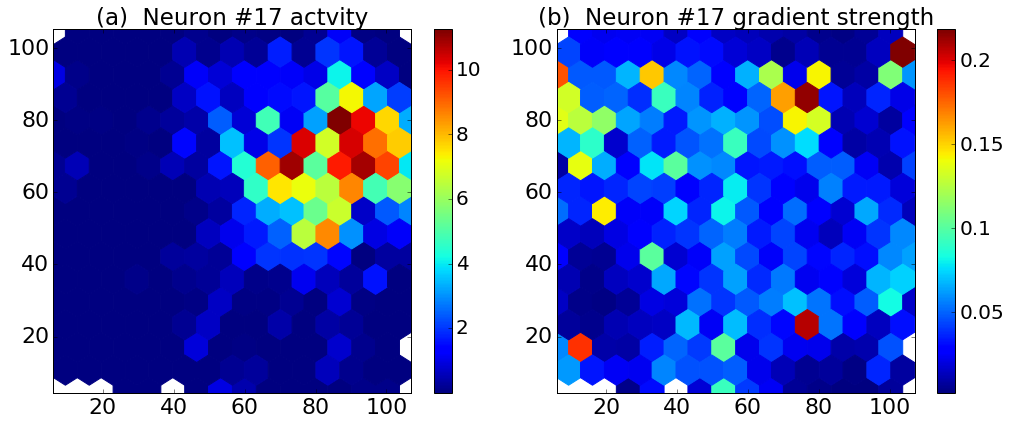

In [13]:
from scipy.stats import binned_statistic


plt.figure(figsize=(14.3,6))
for i in [1]:
    plt.subplot(1,2,2)
    collection_grad = plt.hexbin(targets[...,0], targets[...,1], grad_avg_over_time[...,sorted_idx[-i]], gridsize = 15)
    #plt.hexbin(targets[...,0], targets[...,1], mean_grads[...,99,sorted_idx[-i]], gridsize = 10)
    cbar = plt.colorbar(ticks=[0.05,0.1,0.15,0.2])
    cbar.ax.set_yticklabels([0.05,0.1,0.15,0.2],fontsize=20)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.title("(b)  Neuron #%d gradient strength" % sorted_idx[-i], fontsize=23)

    plt.subplot(1,2,1)
    collection_loc = plt.hexbin(targets[...,0], targets[...,1], used_data[...,sorted_idx[-i]], gridsize = 15)
    #plt.hexbin(targets[...,0], targets[...,1], mean_grads[...,99,sorted_idx[-i]], gridsize = 10)
    cbar = plt.colorbar( ticks=[2,4,6,8,10])
    cbar.ax.set_yticklabels([2,4,6,8,10],fontsize=20)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)

    plt.title("(a)  Neuron #%d actvity" % sorted_idx[-i],fontsize=23)
    
    
    ll= collection_loc.get_array()
    gg= collection_grad.get_array()
    

    max_activity= np.max(X[...,sorted_idx[-i]])
    filtered_activity = X[...,sorted_idx[-i]].copy()
    filtered_activity[np.where(filtered_activity<2)]=0
    print "center of mass of activity:", np.average(y,weights=filtered_activity,axis=0)
plt.tight_layout()

plt.savefig("sensitivity_space_n41_labels.png")

In [14]:
#FOR ALL NEURONS

from scipy.stats import binned_statistic
# activity of the most sensitive neurons
plt.figure(figsize=(14,275))

grad_avg_over_time=np.mean(mean_grads[:,95:,:], axis=1)
#grad_avg_over_time=mean_grads[:,99,:]

print grad_avg_over_time.shape, y.shape, targets.shape
print np.all(y[99:99+442,]==targets[:442])
used_data = []
for i in range(len(y)):
    if y[i,:].tolist() in targets.tolist():
        used_data.append(X[i,:])
    else:
        pass
used_data=np.array(used_data)
print np.shape(used_data)

normalized_activity=np.empty_like(used_data)
normalized_grad=np.empty_like(grad_avg_over_time)

activity_hexes=[]
grad_hexes = []

for i in xrange(63):
    #plt.subplot(63,3,i*3+2)
    collection_grad = plt.hexbin(targets[...,0], targets[...,1], grad_avg_over_time[...,i], gridsize = 10)
    #plt.colorbar()
    #plt.title("Neuron #%d gradient field" % i)

    #plt.subplot(63,3,i*3+1)
    collection_loc = plt.hexbin(targets[...,0], targets[...,1], used_data[...,i], gridsize = 10)
    #plt.colorbar()
    #plt.title("Neuron #%d place field" % i)
    
    ll= collection_loc.get_array()
    gg= collection_grad.get_array()
    
    activity_hexes.append(ll/np.percentile(ll,99))
    grad_hexes.append(gg/np.percentile(gg,99))
    
    #print "axtivity max, 99th percentile  ", np.max(ll), np.percentile(ll,99)
    #print "grad max, 99th percentile  ", np.max(gg), np.percentile(gg,99)
    normalized_activity[...,i] = used_data[...,i]/np.percentile(used_data[...,i],99)
    #print "axtivity max, 99th percentile  ", np.max(used_data[...,i]), np.percentile(used_data[...,i],99)
    normalized_grad[...,i] = grad_avg_over_time[...,i]/np.percentile(grad_avg_over_time[...,i],99)


    #plt.subplot(63,3,i*3+3)
    #averages,edges,ids = binned_statistic(used_data[...,i]/np.max(used_data[...,i]),grad_avg_over_time[...,i],statistic='mean', bins=np.arange(0.0,1,0.1))
    #plt.bar(edges[:-1],averages,width=0.05)
plt.clf()
#plt.show()

(4414, 63) (5404, 2) (4414, 2)
True
(4414, 63)


<Figure size 1008x19800 with 0 Axes>

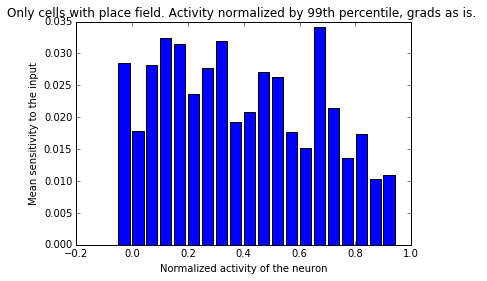

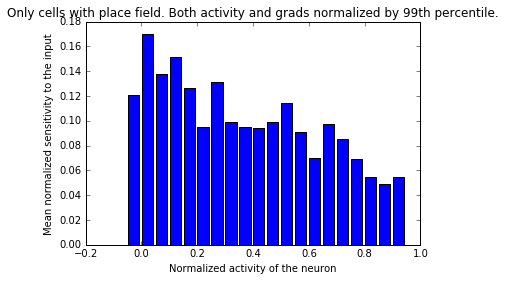

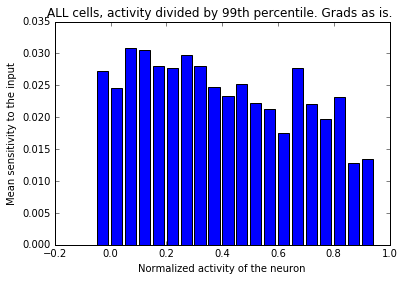

<Figure size 432x288 with 0 Axes>

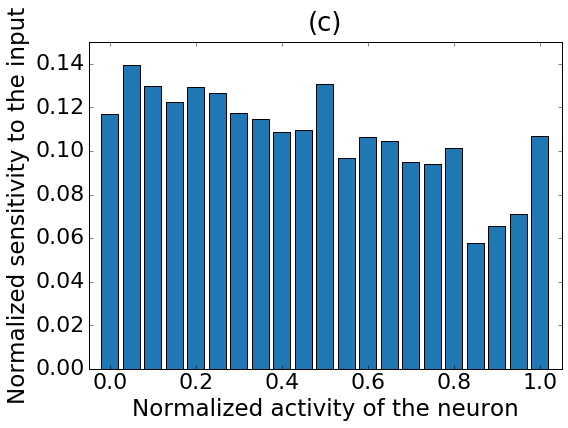

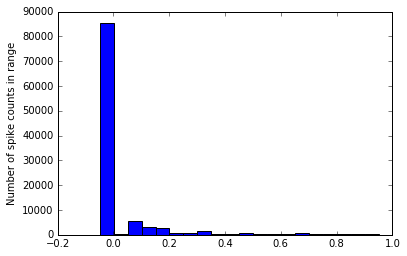

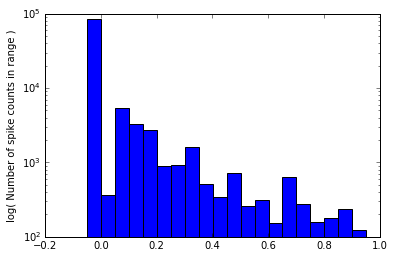

In [15]:

#neurons that have a place-field like thingy
place_cells=[3,4,7,8,11,12,13,14,17,18,21,22,35,37,39,40,49,51,53,54,56,58,60,62]
                                                         
plt.clf()
averages,edges,ids = binned_statistic(np.ravel(normalized_activity[...,place_cells]),np.ravel(grad_avg_over_time[...,place_cells]),statistic='mean', bins=np.arange(-0.049,1,0.05))
plt.bar(edges[:-1],averages,width=0.04)
plt.title("Only cells with place field. Activity normalized by 99th percentile, grads as is. ")
plt.xlabel("Normalized activity of the neuron")
plt.ylabel("Mean sensitivity to the input")
plt.show()

plt.clf()
averages,edges,ids = binned_statistic(np.ravel(normalized_activity[...,place_cells]),np.ravel(normalized_grad[...,place_cells]),statistic='mean', bins=np.arange(-0.049,1,0.05))
plt.bar(edges[:-1],averages,width=0.04)
plt.title("Only cells with place field. Both activity and grads normalized by 99th percentile.")
plt.xlabel("Normalized activity of the neuron")
plt.ylabel("Mean normalized sensitivity to the input")
plt.show()

plt.clf()
averages,edges,ids = binned_statistic(np.ravel(normalized_activity[...,:]),np.ravel(grad_avg_over_time[...,:]),statistic='mean', bins=np.arange(-0.049,1,0.05))
plt.bar(edges[:-1],averages,width=0.04)
plt.title("ALL cells, activity divided by 99th percentile. Grads as is. ")
plt.xlabel("Normalized activity of the neuron")
plt.ylabel("Mean sensitivity to the input")
plt.show()


plt.clf()
plt.figure(figsize=(8,6))
averages,edges,ids = binned_statistic(np.ravel(normalized_activity[...,:]),np.ravel(normalized_grad[...,:]),statistic='mean', bins=np.arange(-0.001,1.05,0.05))
plt.bar(edges[:-1],averages,width=0.04,align='center', color = tableau20[0])
plt.title("ALL cells, both activity and grads normalized by 99th percentile. ")
plt.xlabel("Normalized activity of the neuron", fontsize=23)
plt.ylabel("Normalized sensitivity to the input", fontsize=23)
plt.title("(c)",fontsize=26,y=1.02)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim([-0.05,1.05])
plt.ylim([-0.0,0.15])
plt.tight_layout()
plt.show()
#plt.savefig("grad_f_activity.png")

plt.clf()
plt.hist(np.ravel(normalized_activity[...,place_cells]),bins=np.arange(-0.049,1,0.05))
plt.ylabel("Number of spike counts in range")

plt.show()


plt.clf()
plt.hist(np.ravel(normalized_activity[...,place_cells]),bins=np.arange(-0.049,1,0.05), log=True)
plt.ylabel("log( Number of spike counts in range )")

plt.show()


(4414, 63)


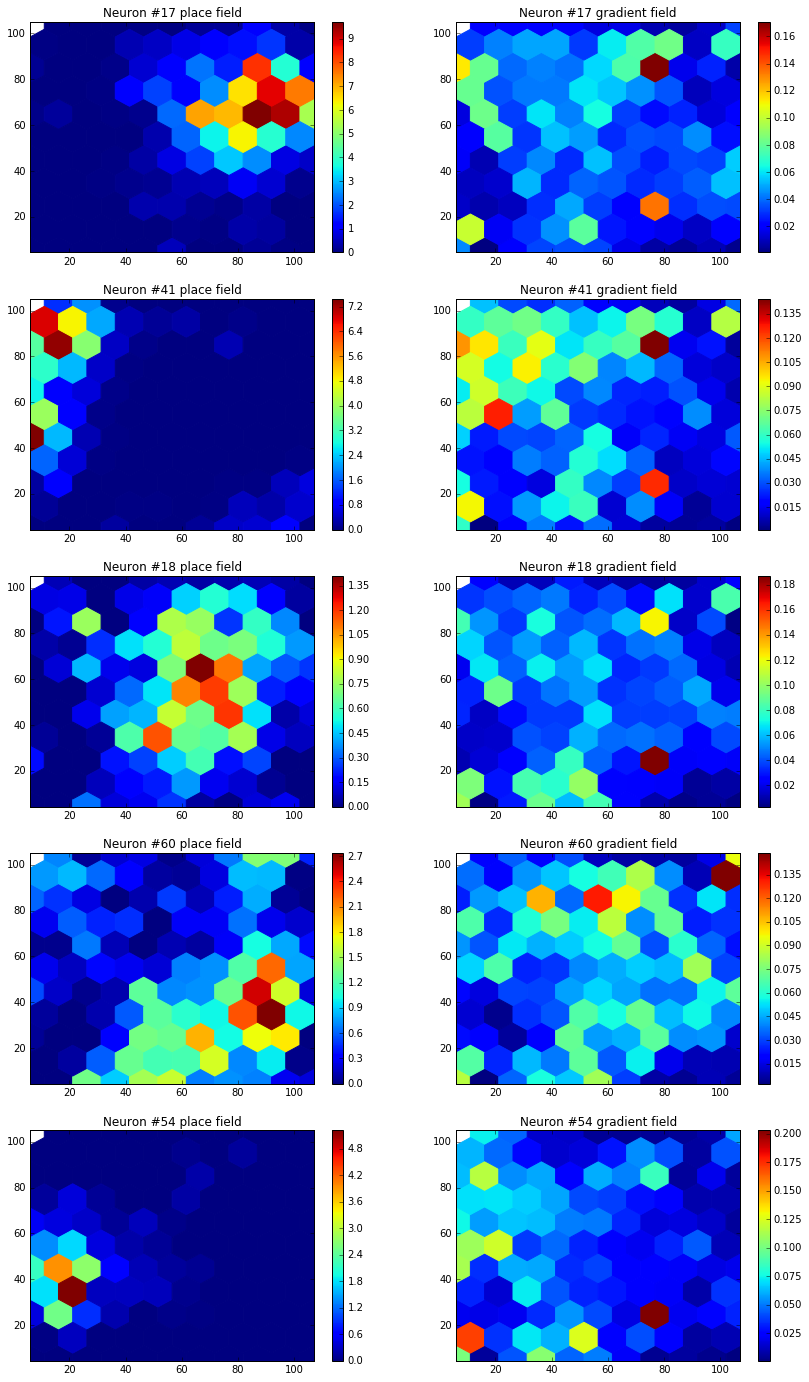

In [16]:
# activity of the most important neurons
plt.figure(figsize=(14,24))
#print np.shape(targets)
#print mean_grads[...,99,sorted_idx[-i]]

#grad_avg_over_time=np.mean(mean_grads[:,95:,:], axis=1)
print grad_avg_over_time.shape

for i in xrange(1,6):
    plt.subplot(5,2,(i-1)*2+2)
    #plt.hexbin(targets[...,0], targets[...,1], grad_avg_over_time[...,sorted_idx[-i]], gridsize = 10)
    plt.hexbin(targets[...,0], targets[...,1], np.abs(mean_grads[...,99,sorted_idx[-i]]), gridsize = 10)
    plt.colorbar()
    plt.title("Neuron #%d gradient field" % sorted_idx[-i])

    plt.subplot(5,2,(i-1)*2+1)
    plt.hexbin(y[...,0], y[...,1], X[...,sorted_idx[-i]], gridsize = 10)
    #plt.hexbin(targets[...,0], targets[...,1], mean_grads[...,99,sorted_idx[-i]], gridsize = 10)
    plt.colorbar()
    plt.title("Neuron #%d place field" % sorted_idx[-i])

In [17]:
# importance of timesteps
timestep_grads = np.mean(np.abs(mean_grads), axis=(0,2))


In [18]:
print np.__version__

print np.shape(mean_grads), np.shape(np.expand_dims(np.linalg.norm(mean_grads, ord=1, axis=2),axis=-1))
normed_grads1 = mean_grads / np.expand_dims(np.linalg.norm(mean_grads, ord=1, axis=2),axis=-1)
normed_grads2 = mean_grads / np.expand_dims(np.linalg.norm(mean_grads, ord=1, axis=2),axis=-1)

1.14.2
(4414, 100, 63) (4414, 100, 1)


## RELATIVE IMPORTANCE

In [19]:
# temporal importance curves of most important neurons

rows = 12
cols = 5
maxy = np.max(normed_neuron_timestep_grads1)*63+0.1
plt.figure(figsize=(12,30))
for i in xrange(1, rows * cols + 1):
    plt.subplot(rows, cols, i)
    plt.plot(normed_neuron_timestep_grads1[:, sorted_idx[-i]]*63)
    plt.axhline(1,linestyle="--",color="gray")
    max_time = 2+np.argmax(normed_neuron_timestep_grads1[2:, sorted_idx[-i]])

    plt.title("Neuron #" + str(sorted_idx[-i])+ "   _at"+str(max_time))
    plt.ylim([0.4, maxy])
plt.tight_layout()
plt.clf() #plt.show()

NameError: name 'normed_neuron_timestep_grads1' is not defined

In [ ]:
# temporal importance curves of most important neurons
print np.shape(normed_neuron_timestep_grads1)
selected_idx=[-1,-2,-3,-4,-5,0]
rows = 2
cols = 3
maxy = np.max(normed_neuron_timestep_grads1)*63+0.1
plt.figure(figsize=(12,6))
clr="blue"
for i in xrange(1, rows * cols + 1):
    plt.subplot(rows, cols, i)
    if i==6:
        clr="red"
    timeseries = normed_neuron_timestep_grads1[:, sorted_idx[selected_idx[i-1]]]*63
    plt.plot(timeseries, color=clr)
    plt.axhline(1,linestyle="--",color="gray")
    plt.title("Neuron #" + str(sorted_idx[selected_idx[i-1]])+" (max at "+str(np.argmax(timeseries)),fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    if i in [1,4]:
        plt.ylabel("Relative importance", fontsize=16)
    if i in [4,5,6]:
        plt.xlabel("Time step", fontsize=16)
    plt.ylim([0.4, maxy])
plt.tight_layout()

In [ ]:
# temporal importance curves of most important neurons
maxy = np.max(normed_neuron_timestep_grads1)*63+0.1
plt.figure(figsize=(8,5))

for i in [1,2,3,-1]:
    plt.plot(range(1,101),normed_neuron_timestep_grads1[:, sorted_idx[-i]]*63)
    #if i==3:
    #    plt.axvline(96, color="r")
    #plt.title("Neuron #" + str(sorted_idx[-i]),fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("Time step",fontsize=18)
    plt.ylabel("Relative importance at time step",fontsize=18)
    plt.ylim([0.5, maxy])
    plt.xlim([0, 100.5])
    plt.legend(["Neuron #","Neuron #","Neuron #","Neuron # (least imp)"],loc=9,fontsize=15)
plt.axhline(1.0,color="gray",linestyle="--")
#plt.title("Temporal importance profiles")
plt.tight_layout()

In [ ]:
# temporal importance curves of most important neurons
maxy = np.max(normed_neuron_timestep_grads1)*63+0.1
plt.figure(figsize=(6,5))

for i in [-2,-1,0]:
    plt.plot(range(1,101),normed_neuron_timestep_grads1[:, sorted_idx[i]]*63)
    #if i==3:
    #    plt.axvline(96, color="r")
    #plt.title("Neuron #" + str(sorted_idx[-i]),fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("Time step",fontsize=18)
    plt.ylabel("Relative importance at time step",fontsize=18)
    plt.ylim([0.4, 1.8])
    plt.xlim([0, 100.5])
    plt.legend(["Neuron #","Neuron #","Neuron #"],loc=2,fontsize=15)
plt.axhline(1.0,color="gray",linestyle="--")
#plt.title("Temporal importance profiles")
plt.tight_layout()